<a href="https://colab.research.google.com/github/hoaileba/AI-doc/blob/master/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os,cv2,keras,glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=False,input_shape = (224,224,3))

In [2]:
from zipfile import ZipFile

# file_image = "/content/drive/My Drive/Colab Notebooks/data/Images.zip"
# with ZipFile(file_image,'r') as zp:
#   # zip.printdir()
#   zp.extractall()
#   print('done')
# files = '/content/drive/My Drive/Colab Notebooks/data/Airplanes_Annotations.zip'
# with ZipFile(files,'r') as zp:
#   # zip.printdir()
#   zp.extractall()
#   print('done')
files = '/content/drive/My Drive/data.zip'
with ZipFile(files,'r') as zp:
  # zip.printdir()
  zp.extractall()
  print('done')

done


In [0]:
path = "/content/data_dog"
annot = "/content/label_dog"
import os

dirVal = '/content/pre'
dirValImage = dirVal+'/0'
dirValLabel = dirVal+'/1'
os.mkdir(dirVal)
os.mkdir(dirValImage)
os.mkdir(dirValLabel)

In [0]:


import glob

Image_path = path+ '/*.jpg'
label_path = annot + '/*.txt'
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

all_image = glob.glob(Image_path)
all_label = glob.glob(label_path)

all_image.sort()
all_label.sort()

def IoU(box1, box2):
  x1,y1,x2,y2 = box1['x1'],box1['y1'],box1['x2'],box1['y2']
  # print(x1,y1,x2,y2)
  xx1,yy1,xx2,yy2 = box2['x1'],box2['y1'],box2['x2'],box2['y2']
  # print(xx1,yy1,xx2,yy2)
  x1_i = max(x1,xx1)
  y1_i = max(y1,yy1)
  x2_i = min(x2,xx2)
  y2_i = min(y2,yy2)
  # print(x1_i,y1_i,x2_i,y2_i)
  # if x1_i > x2_i or y1_i > y2_i:
  #   return 0.0,

  s_inter = (x2_i - x1_i)*(y2_i - y1_i)
  S_b1 = (x2 - x1)*(y2-y1)
  S_b2 =  (xx2 - xx1)*(yy2-yy1)
  # print(s_inter,S_b1,S_b2)
  # if s_inter == S_b1 :
  if x1_i > x2_i or y1_i > y2_i:
    return 0.0,s_inter,S_b1,S_b2
  IOU  = s_inter / float(S_b1+S_b2 - s_inter)
  return IOU,s_inter,S_b1,S_b2

Train_image= []
Train_label = []
cnt = 0
dem = 0
for i in all_image:

        dem+=1
        # if(dem%100 == 0) :
        #   print(dem)

        fileI = i.split("/")[-1]
        fileL = annot+'/'+fileI.split('.')[0]+ '.txt'
        # print(fileI, fileL)
        img = cv2.imread(i)

        grTrue = []
        f = open(fileL, "r")
        data = []
        for ind in f:
          data.append(ind)

        num_ob = int(data[0])

        for id in range(num_ob):
          co = data[id+1].split(' ')
          # print(co[0])
          num = []
          for fi in co:
            if fi != '\n':
              n = float(fi)
              num.append(float(fi))
          x1 = int(num[0]*224)
          y1 = int(num[1]*224)
          x2 = int(num[2]*224)
          y2 = int(num[3]*224)
          # print(x1,y1,x2,y2)
          grTrue.append({'x1':x1,'y1':y1, 'x2':x2 , 'y2' : y2})
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchQuality()
        rects = ss.process()
        imOut = img.copy()
        # cnt = 0
        pos = 0
        neg = 0
        dem = 0
        for e,rect in enumerate(rects):
          check = False
          iou= 0.0
          # print(rect[0])
          if e > 2000 or(neg >30 and pos > 30):
            break 
          for tr in grTrue:
              x, y, w, h = rect
              i,inter,S1,S2 = IoU(tr,{"x1":x,"y1":y,"x2":x+w,"y2":y+h})
              if( i > iou):
                iou = i

          if iou > 0.75 and pos < 30:
            imO = imOut[x:x+w,y:y+h]
            resized = cv2.resize(imO, (224,224), interpolation = cv2.INTER_AREA)
            cnt+=1
            file_image_name = '/content/pre/1/'+ str(cnt)+'.jpg' 
            cv2.imwrite(file_image_name,resized)
            pos+=1
            
      # print(dem)      
          if iou < 0.3 and neg <30:
            imO = imOut[x:x+w,y:y+h]
            resized = cv2.resize(imO, (224,224), interpolation = cv2.INTER_AREA)
            cnt+=1
            file_image_name = '/content/pre/0/'+ str(cnt)+'.jpg' 
            cv2.imwrite(file_image_name,resized)
            # cv2.rectangle(imOut,(x,y),(x+w,y+h),(0,255,0), 2)
            neg+=1

        print(dem,neg,pos)

In [33]:
file1 = glob.glob("/content/1/*.jpg")
file0 = glob.glob("/content/0/*.jpg")
from keras.utils import to_categorical
class_= np.array(['0','1'])

import os
files = []
for f in file1:
  files.append(f)
for f in file0:
  files.append(f)
# print()
import random
random.shuffle(files)
sep = tf.strings.split(files[100],'/')[-2]
print(len(files))
print(int(sep))
def Process(img_path):
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image,channels = 3)
  image = tf.cast(image,tf.float32)/255.0
  image = tf.image.resize(image,(224,224))
  parts = tf.strings.split(img_path, os.path.sep)
  y=parts[-2]==class_
  
  return image,y

data_list=tf.data.Dataset.from_tensor_slices(files).map(Process,num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_list = data_list.shuffle(100)
print()



59257
1



In [0]:
!zip -r /content/file.zip /content/pre

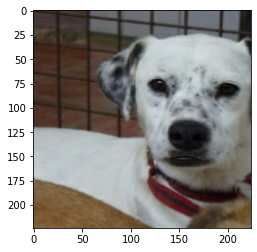

[False  True]


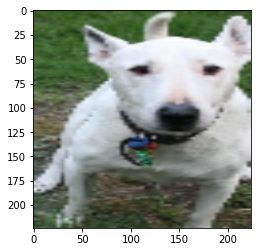

[False  True]


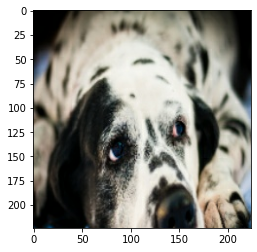

[False  True]


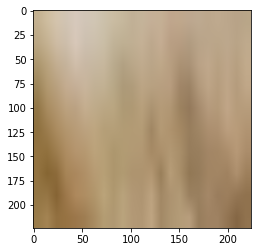

[ True False]


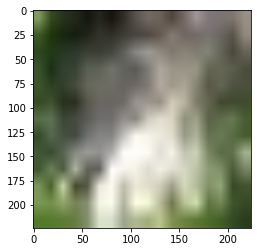

[ True False]


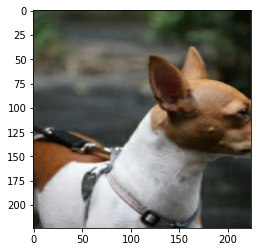

[False  True]


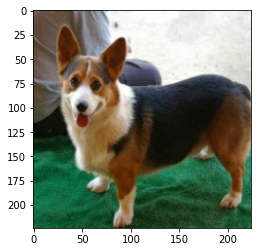

[False  True]


In [84]:
pos = 0
neg = 0
X = []
Y = []
img = data_list.take(1)
for img,lab in data_list.take(7):
  x = np.array(img)
  plt.imshow(img.numpy())
  plt.show()
  print(lab.numpy())
def IoU(box1, box2):
  x1,y1,x2,y2 = box1['x1'],box1['y1'],box1['x2'],box1['y2']
  # print(x1,y1,x2,y2)
  xx1,yy1,xx2,yy2 = box2['x1'],box2['y1'],box2['x2'],box2['y2']
  # print(xx1,yy1,xx2,yy2)
  x1_i = max(x1,xx1)
  y1_i = max(y1,yy1)
  x2_i = min(x2,xx2)
  y2_i = min(y2,yy2)
  # print(x1_i,y1_i,x2_i,y2_i)
  # if x1_i > x2_i or y1_i > y2_i:
  #   return 0.0,

  s_inter = (x2_i - x1_i)*(y2_i - y1_i)
  S_b1 = (x2 - x1)*(y2-y1)
  S_b2 =  (xx2 - xx1)*(yy2-yy1)
  # print(s_inter,S_b1,S_b2)
  # if s_inter == S_b1 :
  if x1_i > x2_i or y1_i > y2_i:
    return 0.0,s_inter,S_b1,S_b2
  IOU  = s_inter / float(S_b1+S_b2 - s_inter)
  return IOU,s_inter,S_b1,S_b2
# from keras.utils import to_categorical
# y =  to_categorical(y,num_classes=2)

In [75]:

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout,Flatten
from tensorflow.keras.models import Sequential
def loss_SVM(y_true,y_pred):


    score=tf.reduce_sum(y_true*y_pred,axis=1,keepdims=True)
   
    loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, y_pred - score + 1), 1)) - 1

    return loss
# vggmodel.summary()
# for layers in (vggmodel.layers)[:15]:
#     print(layers)
#     layers.trainable = False
model=tf.keras.Sequential([
                           vggmodel,
                          #  tf.keras.layers.Flat
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(1024,activation='relu'),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dropout(0.5),
                           tf.keras.layers.Dense(1024,activation='relu'),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dropout(0.5),
                           tf.keras.layers.Dense(512,activation='relu'),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dropout(0.5),
                           tf.keras.layers.Dense(2, activation='softmax')
                           
])
# model.add(Dense(units = 2, activation = 'softmax'))
# X= vggmodel.layers[-2].output
# predictions = Dense(2,activation = 'softmax')(X)
# model = tf.keras.models.Model(inputs = vggmodel.input, outputs = predictions)
model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

model.summary()
# X = np.array(Train_image)
# Y = np.array(Train_label)
# print(X.shape,Y.shape)
# from keras.utils import to_categorical
# print(Y)
# y = to_categorical(Y, num_classes=2)
train = data_list.batch(100)
model.fit(train.repeat(),steps_per_epoch=59257//100,epochs= 2)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_24 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_25 (Batc (None, 1024)             

1.0


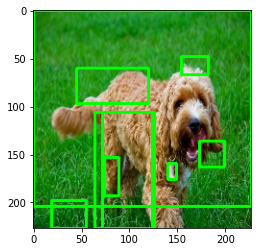

/content/00ecc67a6c3a048c.jpg
1
[0.08157400000000001, 0.23848200000000006, 0.878545, 0.999817]
18 53 196 223
[[0. 1.]]


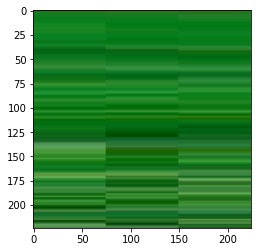

[[0. 1.]]


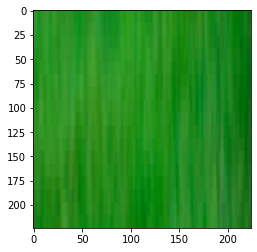

[[0. 1.]]


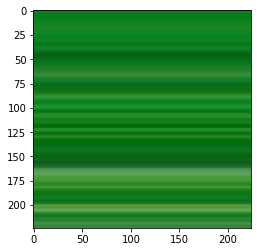

[[0. 1.]]


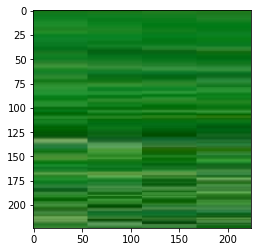

[[0. 1.]]


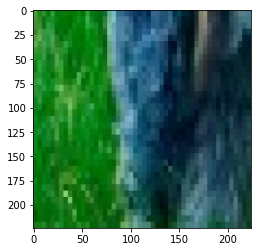

[[0. 1.]]


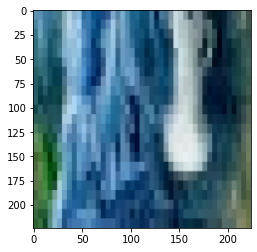

[[0. 1.]]


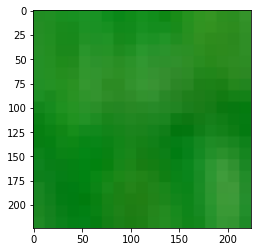

[[0. 1.]]


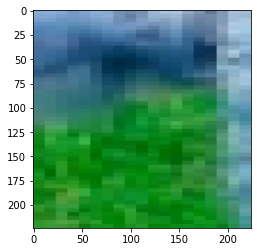

[[0. 1.]]


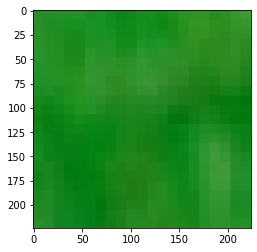

[[1. 0.]]


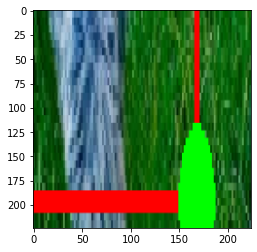

[[2.381393e-18 1.000000e+00]]


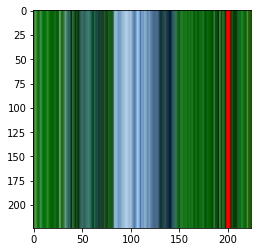

[[0. 1.]]


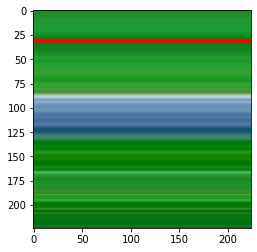

[[0. 1.]]


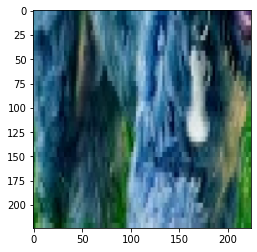

[[0. 1.]]


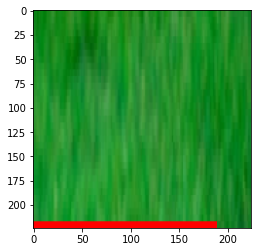

[[0. 1.]]


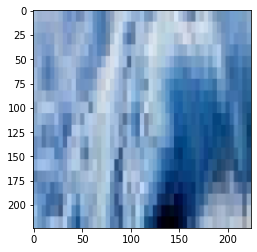

[[0. 1.]]


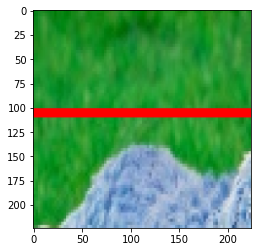

[[0. 1.]]


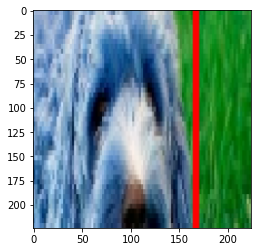

[[0. 1.]]


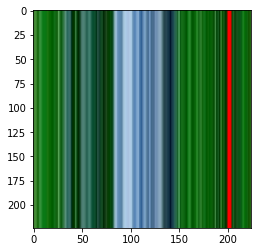

[[0. 1.]]


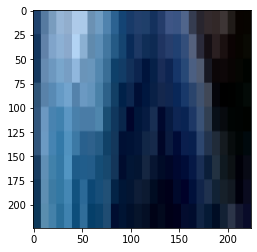

[[0. 1.]]


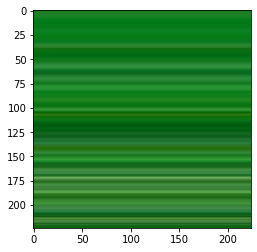

[[1. 0.]]


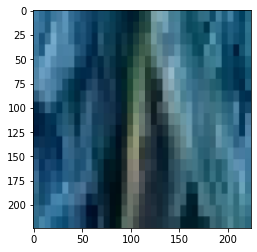

[[0. 1.]]


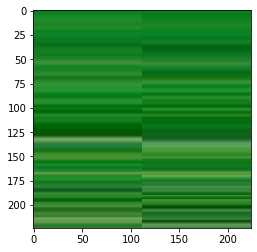

[[0. 1.]]


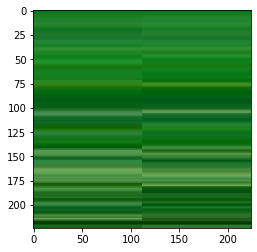

[[0. 1.]]


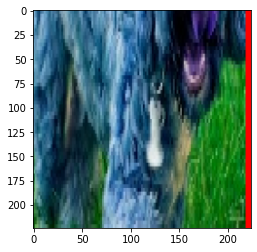

[[0. 1.]]


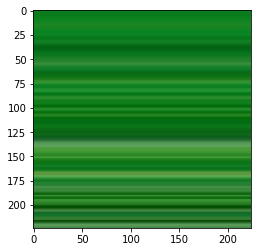

[[0. 1.]]


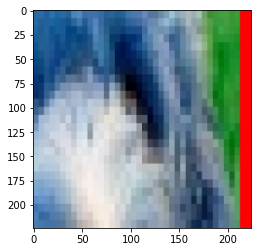

[[0. 1.]]


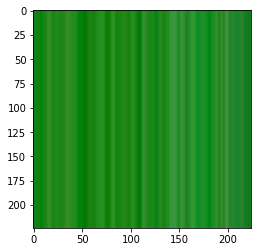

[[0. 1.]]


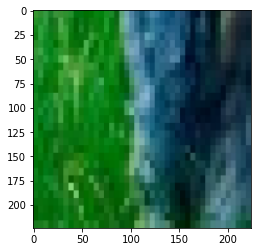

[[0. 1.]]


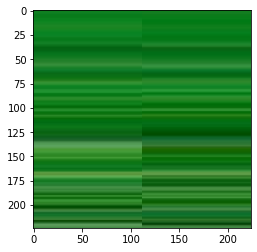

[[0. 1.]]


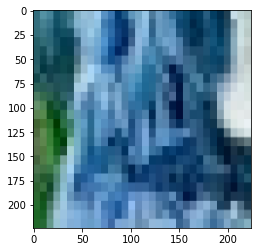

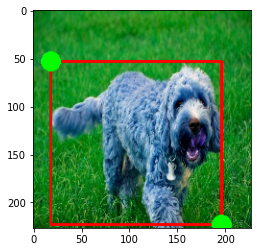

In [90]:
# print(model.layers[-1].config/)
img = cv2.imread("/content/00ecc67a6c3a048c.jpg")
# print(img.shape)
# plt.imshow(img)
# plt.show()
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# print(img.shape)
# ans=model.predict(img)
# print(ans)
# ans=np.argmax(ans,axis=1)
# print(ans)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
dem = 0
x1 = []
y1= []
h1 = []
w1= []
pred = 0.0
score = []
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        imwg = np.array(cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)).reshape(1,224,224,3)
        out= model.predict(imwg)
        # print(out)
        if out[0][1] > 0.95:
            score.append(pred)
            if pred < out[0][1]:
              pred = out[0][1]
              
            x1.append(x)
            y1.append(y)
            h1.append(h)
            w1.append(w)
            dem+=1
            if dem == 10 :
              break
            # break
        # iv = np.array(imwg).reshape(224,224,3)
print(pred)
for i,pre in enumerate(score):
  if pre == pred:
    cv2.rectangle(imout,(x1[i],y1[i]),(x1[i]+w1[i],y1[i]+h1[i]),(0,255,0), 2)
plt.figure()
plt.imshow(imout)
plt.show()
# for img,lab in data_list.take(20):
#   images = np.array(img)
#   plt.imshow(img.numpy())
#   plt.show()
#   images = images.reshape(1,224,224,3)
#   print(model.predict(images),lab.numpy())

filename = "/content/00ecc67a6c3a048c.jpg"
print(filename)
ig = cv2.imread(filename)
f = open("/content/00ecc67a6c3a048c.txt", "r")
x = []

for i in f:
  x.append(i)
# plt.imshow(ig)
numob = int(x[0])
tr = {}
print(numob)
for i in range(numob):
    co = x[i+1].split(' ')
    # print(co[0])
    num = []
    for fi in co:
      if fi != '\n':
        n = float(fi)
        num.append(float(fi))

    print(num)
    x1 = int(num[0]*224)
    y1 = int(num[1]*224)
    x2 = int(num[2]*224)
    y2 = int(num[3]*224)
    print(x1,y1,x2,y2)
    tr['x1'] = x1
    tr['y1'] = y1
    tr['x2'] = x2
    tr['y2'] = y2
    cv2.rectangle(ig,(x1,y1),(x2,y2),(255,0,0), 2)
    cv2.circle(ig, (x1,y1), 5, (0, 255, 0), 10)
    cv2.circle(ig, (x2,y2), 5, (0, 255, 0), 10)

ss.setBaseImage(ig)
ss.switchToSelectiveSearchQuality()
rects = ss.process()
imOut = ig.copy()
# cnt = 0
pos = 0
neg = 0
dem = 0
for e,rect in enumerate(rects):
  check = False
  iou= 0.0
  # print(rect[0])
  if e > 2000 or(neg >30 and pos > 30):
    break 

  x, y, w, h = rect
  i,inter,S1,S2 = IoU(tr,{"x1":x,"y1":y,"x2":x+w,"y2":y+h})
  if( i > iou):
    iou = i

  if iou < 0.25 and pos < 30:
    imO = imOut[x:x+w,y:y+h]
    resized = cv2.resize(imO, (224,224), interpolation = cv2.INTER_AREA)
    predd = np.array(resized).reshape(1,224,224,3)
    print(model.predict(predd))
    # cnt+=1
    # file_image_name = '/content/pre/1/'+ str(cnt)+'.jpg' 
    # cv2.imwrite(file_image_name,resized)
    pos+=1
    plt.imshow(resized)
    plt.show()

plt.figure()
plt.imshow(ig)

Như ta đã biết CNN là mạng được biết rộng rãi và nhiệm vụ của nó là phân tích đặc trưng của ảnh cho nó thành feature map để phục vụ nhiều công việc khác nhau như nhận diện ảnh và đặc biệt là định vị ảnh. nếu như Unet hay Unet++(Nested UNet) ta sẽ phân ảnh thành các tập riêng rẽ thì giờ ta có thể sử dụng các tập đó để định vị bằng cách vẽ lên đó những ô viền để đánh dấu object và mạng xây dựng để định vị là R-CNN kết hợp với Bounding-Box



#Region proposals:
Bước đầu tiên trong việc có thể định vị object ở đâu là ta sẽ phân tập bức ảnh thành nhiều tập con mà trong đó nó có thể chứa object. và thuật toán đucợ dùng nhiều đó là Selective search( một thuật toán trên đồ thị ) 

![alt text](https://miro.medium.com/max/964/1*eGvz2lCeqkAV7Pd4V4xDnw.png)

Sau khi ta đã phân tích bức ảnh ra thành nhiều khung hình có thể chứa object chúng ta sẽ đến phần tiếp theo phân tích đặc trưng của từng ảnh


#Feature Extraction:
Nếu như ở bước trên ta có những khung hình đc cho là có thể có vật thể trong đó nên ở bước này sẽ gần như chúng ta thực hiện bài toán phân loại nhằm mục ddinhchs là train lại cho model của ta nhận diện được đâu là background đâu là vật thể và các đơn giản là dùng CNN để tạo ra các feature cho các đối tượng và cho background là bước phân tích để phục vụ cho bươc tiếp theo.

#Phân Loại:

Sau khi đã có feature cho từng khung hình ta sẽ phân loại nó dựa trên các feature. Ở đây có nhiều các để phân loại nó có thể dùng Softmax như các cách nhận diện MNIST nhưng theo như paper gốc của tác giả thì họ dùng SVM thay vì dùng CNN với softmax.

![alt text](https://miro.medium.com/max/1400/1*a2I7qwF3Z_hPcmAkmL7_YA.png)


# Bounding Box Regression:

Sau khi ta dự đoán 1 khung hình nào đó là vật thể nhưng nó thể hiện việc định vị quá xấu vì nó phụ thuộc rất nhiều vào Selective Search và những khung ảnh được đưa ra ko phải lúc nào cũng đẹp. Nên chúng ta sẽ phải tinh chỉnh lại phần này. bằng cách khi train ta sẽ lôi ra 4 số đó là tọa độ điểm của box predict xem nó như feature của 1 bài toán Regression và từ 4 ta sẽ học dần cách để tinh chỉnh khung sao cho phù hợp.

Cách làm như sau:

>$P^i$ là phần region được cho ra từ Selective Search

>$G$ là label, là phần box chính xác được tạo ra ban đầu

Sau khi P đi qua lớp Fully Connected ta có được 1 vector feature là $Z$ và để có được đầu ra dự đoán thì ta làm theo như feed forward đơn giản đó là lấy weight của Layer cuối $W$ nhân với $Z$ như vậy đầu ra dự đoán là:

>$Phat = W.Z$ 

Ta có nhãn để training cho model là
$T$ với:

$T_x = (G_x - P_x)/P_w$ 

$T_y = (G_y - P_y)/P_h$

$T_w = log(G_w/P_w)$

$T_h = log(G_h/P_h)$

Lúc nay ta có Loss của Công việc này là:

$ L = MSE(T,Phat) = \sum_{i = 0}^{N} (T^i - P^i)^2 - \lambda ||w||^2$ 

bây giờ việc quan trọng là tối ưu hàm mất mát ở trên

Đánh Giá :
 Do RCNN sử dụng Selective Search để tìm ra toàn bộ các box có thể chứa thực thể sau đó ta lại đi phân loại từng box và sau đó chỉnh box nên quá trình này tốn nhiều thời gian nên khó có thể áp dụng RCNN trong việc nhận diện và detect real time được. Kèm theo đó lad 1 lượng data sinh ra cực kì lớn với code ở trên thực hiện với 1500 ảnh sau khi phân tách ra thì là hơn 60000 ảnh để phân loại.

